# Project 5 : Human segmentation

### - Rubric

#### 1. 인물모드 사진을 성공적으로 제작하였다.
  - **아웃포커싱** 효과가 적용된 **인물**모드 사진과 **동물** 사진, **배경전환** 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

#### 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.	
  - 인물사진에서 발생한 **문제점**을 정확히 지적한 사진을 제출하였다.

#### 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.	
  - semantic segmentation mask의 **오류**를 **보완**할 수 있는 좋은 솔루션을 **이유**와 함께 제시하였다.

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

from pixellib.semantic import semantic_segmentation

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/human'
file_list = sorted(os.listdir(dir_path))
file_num = len(file_list)
print(file_list)

['image1.jpg', 'image2.jpg']


Image ref:

[image1]('https://www.pexels.com/ko-kr/photo/16261963/'),
[image2]('https://www.pexels.com/ko-kr/photo/16261965/')

[horse]('https://www.pexels.com/ko-kr/photo/635499/'),
[landscape]('https://www.peakpx.com/en/hd-wallpaper-desktop-eurbv')

In [3]:
#load images 
def load_img():
    
    img_dict = {}
    for file in file_list:
        img_path = os.path.join(dir_path,file)
        img = cv2.imread(img_path)
        
        img_dict[file] = img
    
    return img_dict

In [4]:
#show images
def show_img(img_dict,row,col):
    
    fig, ax = plt.subplots(row,col,figsize = (20,20))
    img_name_list = list(img_dict.keys())
    
    print(img_name_list)
    
    for i in range(col*row):
        
        img_name = img_name_list[i]
        img_rgb = cv2.cvtColor(img_dict[img_name],cv2.COLOR_BGR2RGB)
        
        ax[i].imshow(img_rgb)
        ax[i].set_title(img_name)
        
    plt.show()

['image1.jpg', 'image2.jpg']


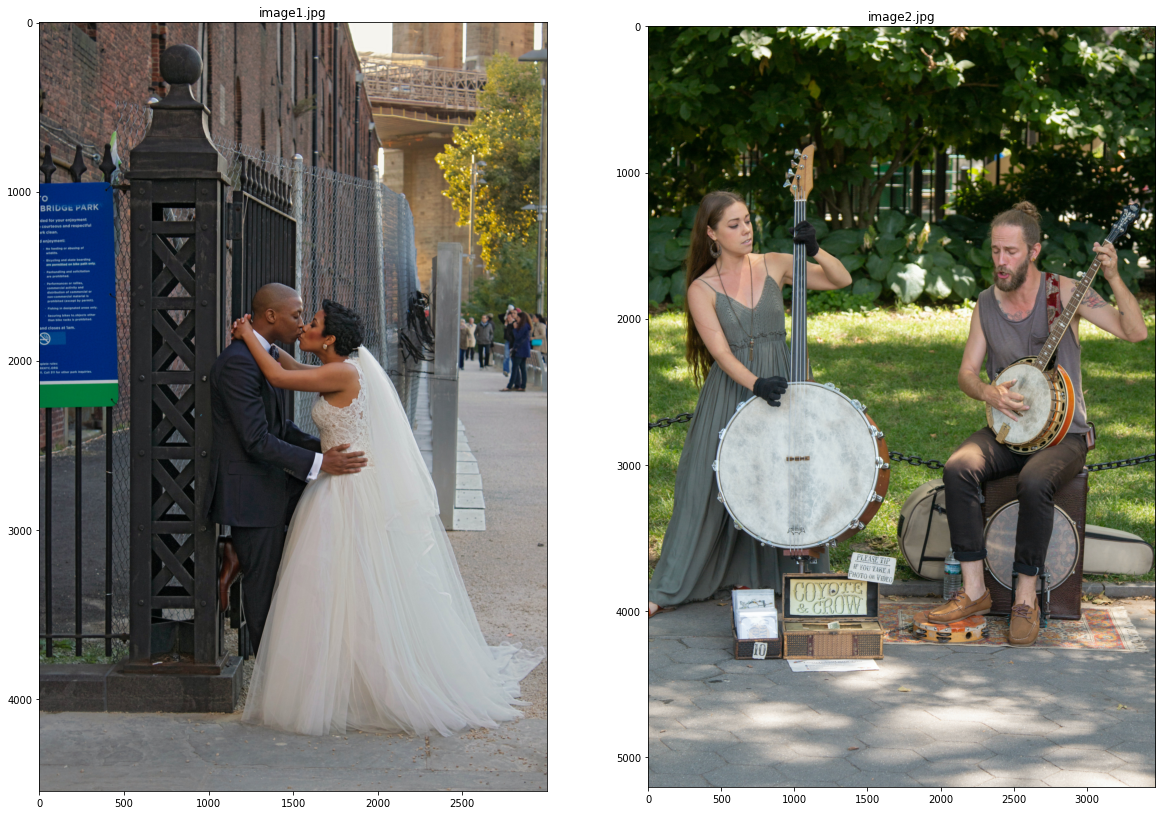

In [5]:
#show image
image_dict = load_img()
image_dict = dict(image_dict.items())
show_img(image_dict,1,file_num)

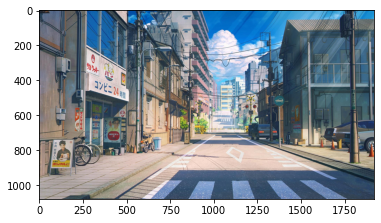

In [6]:
landscape_path = './images/landscape.jpg'
landscape_bgr = cv2.imread(landscape_path)
landscape_rgb = cv2.cvtColor(landscape_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(landscape_rgb)

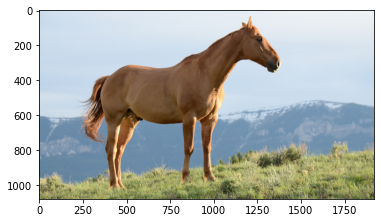

In [7]:
horse_path = './images/horse.jpg'
horse_bgr = cv2.imread(horse_path)
horse_rgb = cv2.cvtColor(horse_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(horse_rgb)

## Step 1. 인물모드 직접 해 보기

### 1-1 model load

In [8]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듦

model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

{'class_ids': array([ 0,  2, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
background
bicycle
person


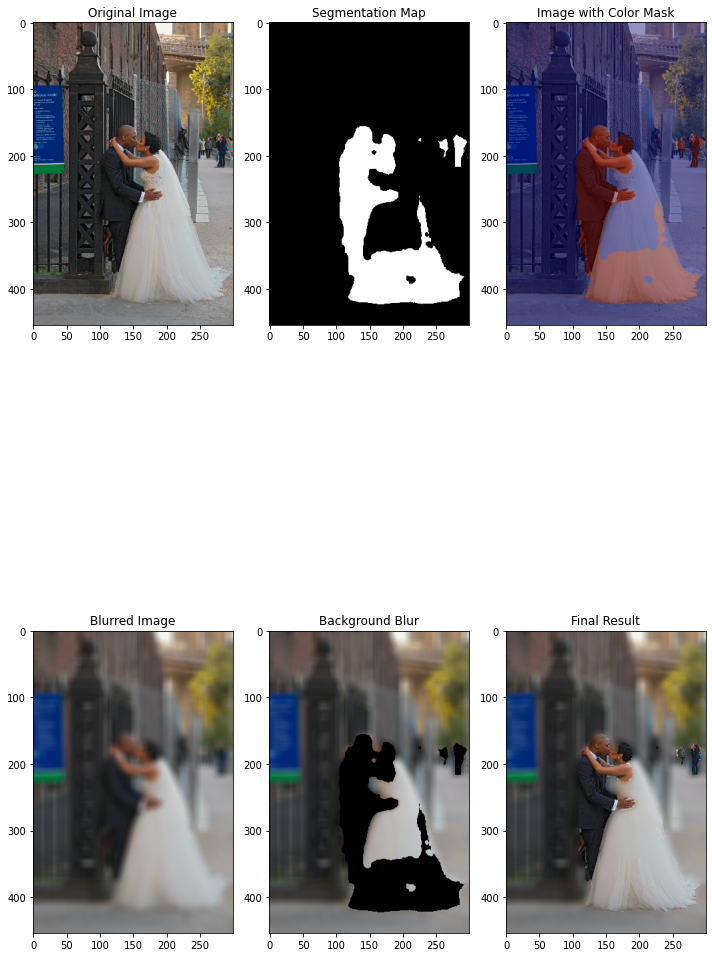

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
background
person


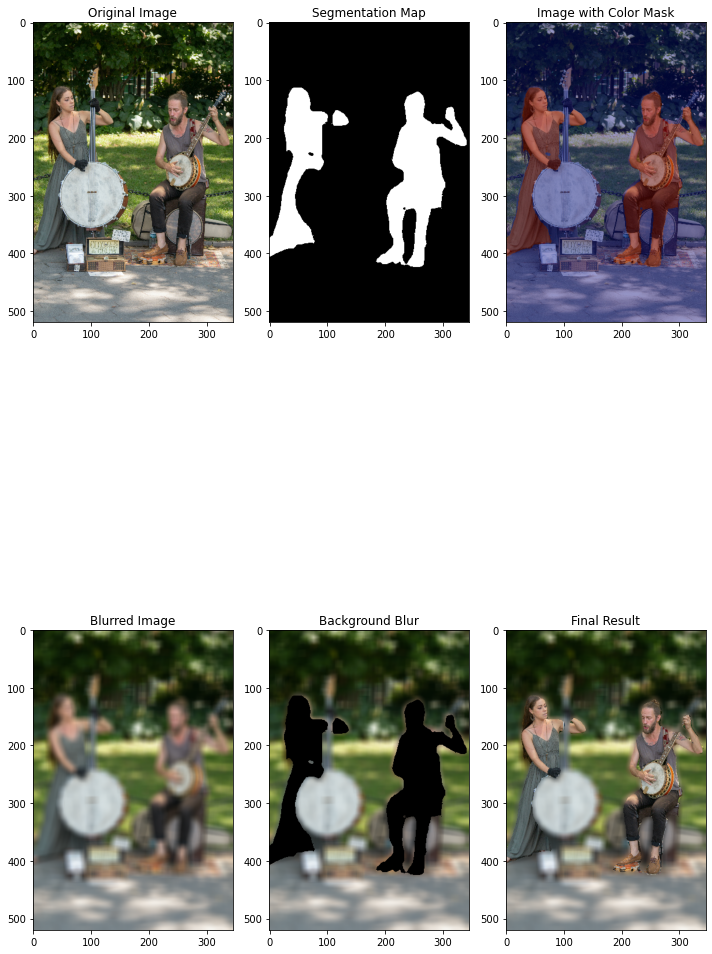

In [10]:
import matplotlib.pyplot as plt

for file in file_list:
    img_path = os.path.join(dir_path, file)
    
    scale_percent = 0.1     # 이미지 해상도가 높아서 1/10로 리스케일링
    img = cv2.imread(img_path)
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    
    img_orig = cv2.resize(img, dim)

    fig = plt.figure(figsize=(10, 20))  

    ax1 = fig.add_subplot(231)
    ax1.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')

    segvalues, output = model.segmentAsPascalvoc(img_path)
    print(segvalues)
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])

    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    seg_color = (128, 128, 192)
    seg_map_bool = np.all(output == seg_color, axis=-1)
    seg_map_int = seg_map_bool.astype(int)
    seg_map_resized = cv2.resize(seg_map_int, dim, interpolation = cv2.INTER_NEAREST)

    ax2 = fig.add_subplot(232)
    ax2.imshow(seg_map_resized, cmap='gray')
    ax2.set_title('Segmentation Map')

    img_show = img_orig.copy()
    img_mask = seg_map_resized.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    ax3 = fig.add_subplot(233)
    ax3.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    ax3.set_title('Image with Color Mask')

    img_orig_blur = cv2.blur(img_orig, (13, 13))

    ax4 = fig.add_subplot(234)
    ax4.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    ax4.set_title('Blurred Image')

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    ax5 = fig.add_subplot(235)
    ax5.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    ax5.set_title('Background Blur')

    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

    ax6 = fig.add_subplot(236)
    ax6.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    ax6.set_title('Final Result')

    plt.tight_layout()
    plt.show()


## Step 2. 인물 segmentation에서 발생한 문제점

펑퍼짐한 드레스에 대해서 인간의 옷으로 인식하기 보다 인간이 아닌 무언가로 인식했다
색의 문제 일 가능성도 열어 두어야 하는 이유는 드레스의 밑단은 사람으로 인식했기 때문이고, 모델의 집중도가 남편의 손으로 인해 그곳으로 쏠리면서 오히려 드레스의 집중력을 흡수(?) 한것으로 추정된다. 악기를 다루는 여성분의 드레스는 인간으로 segmentation 잘 된것을 보면 모델의 성능은 드레스를 인식함을 알 수 있다. 즉, 다중객체 인식으로 인한 문제가 발생했음을 의미한다. 더 나아가서 동일 클래스의 다중객체에 대한 인식 성능이 떨어짐을 확인 할 수 있었다.

<table>
  <tr>
    <td> <img src="./images/a/1.PNG" alt="Image 1" style="width: 250px;"/> </td>
    <td> <img src="./images/a/2.PNG" alt="Image 2" style="width: 250px;"/> </td>
  </tr>
</table>

## Step 3. 해결 방법을 제안

Image Segmentation은 이미지를 픽셀 단위로 분석하고, 각 픽셀이 어떤 범주에 속하는지를 분류하는 과정이다. 이번 프로젝트에서는 Semantic Segmentation을 사전 학습시킨 모델이 사용됐다.

Semantic Segmentation은 이미지 내의 각 픽셀이 어떤 클래스에만 속하는지 판별하는 방법으로, 이미지 내의 객체를 픽셀 단위로 정확하게 구분함으로써 이미지 이해에 중요한 역할을 한다.

이번에 발생한 문제는 같은 특성을 가진 다른 객체들에 대해서는 인식률이 떨어진다는 것이다. 이 문제는 Instance Segmentation로서 해결 될 수 있다. 이 모델은 각 객체를 개별적으로 인식하므로, 다중 객체 인식에 더 효과적임을 알 수 있다.

![df](./images/a/E-14-5.max-800x600_YNvIU7P.png)
[MS COCO datasets의 인스턴스 세그멘테이션 라벨 (출처: http://cocodataset.org/#explore)]

## horse with blurred background

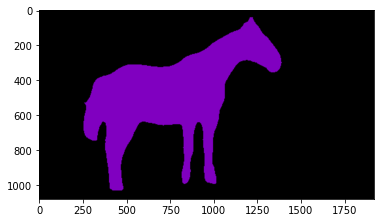

In [11]:
segvalues, output = model.segmentAsPascalvoc(horse_path)
plt.imshow(output)
plt.show()

In [12]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
horse


In [13]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

print(colormap.shape)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[13]

(256, 3)


array([192,   0, 128])

(1080, 1920)


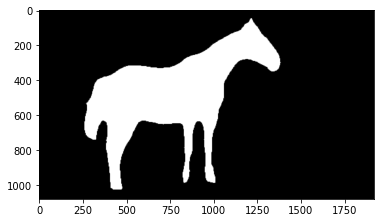

In [14]:
horse_seg_color = (128,0,192)

horse_seg_map = np.all(output==horse_seg_color, axis=-1) 
print(horse_seg_map.shape) 
plt.imshow(horse_seg_map, cmap='gray')
plt.show()

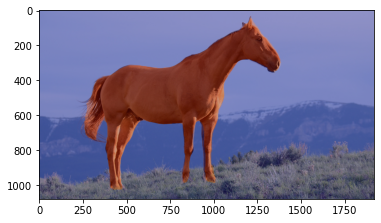

In [15]:
horse_show = horse_bgr.copy()

horse_mask = horse_seg_map.astype(np.uint8) * 255


horse_color_mask = cv2.applyColorMap(horse_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
horse_show = cv2.addWeighted(horse_show, 0.6, horse_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(horse_show, cv2.COLOR_BGR2RGB))
plt.show()

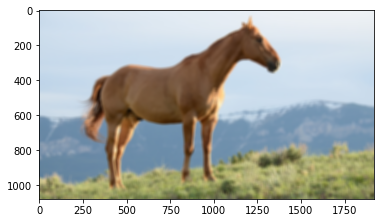

In [16]:
horse_orig_blur = cv2.blur(horse_bgr, (20, 20))
plt.imshow(cv2.cvtColor(horse_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

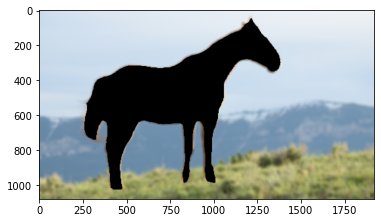

In [17]:
horse_mask_color = cv2.cvtColor(horse_mask, cv2.COLOR_GRAY2BGR)

horse_bg_mask = cv2.bitwise_not(horse_mask_color)

horse_bg_blur = cv2.bitwise_and(horse_orig_blur, horse_bg_mask)
plt.imshow(cv2.cvtColor(horse_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

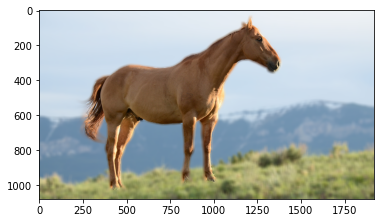

In [18]:
horse_concat = np.where(horse_mask_color==255, horse_bgr, horse_bg_blur)
plt.imshow(cv2.cvtColor(horse_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Replace the background

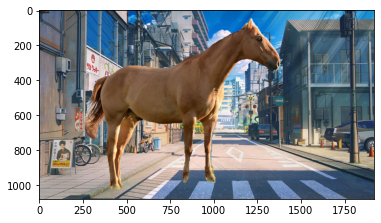

In [19]:
horse_seg_map_3D = horse_seg_map.astype(np.uint8) * 255
horse_seg_map_3D = cv2.cvtColor(horse_seg_map_3D, cv2.COLOR_GRAY2BGR)
result = np.where(horse_seg_map_3D==255, horse_bgr, landscape_bgr)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()